In [1]:
import numpy as np
import minterpy as mp
import matplotlib.pyplot as plt

from utils_base import eval_newton_driver_base
from utils_numba import eval_newton_driver_numba_cpu
from utils_numba_par import eval_newton_driver_numba_cpu_par

c:\Users\wicaks72\AppData\Local\anaconda3\envs\cuda\lib\site-packages\numba\core\typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "utils_numba_par.py", line 19:
@njit(void(F_1D, I_2D, F_2D, I_1D, F_2D, F_1D), parallel=True, cache=True)  # O(Nm)
def eval_newton_monomials_single(
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [2]:
def runge(xx):
    return 1 / (1 + np.sum(xx**2, axis=1))

In [9]:
mi = mp.MultiIndexSet.from_degree(
    spatial_dimension=4,
    poly_degree=15,
    lp_degree=2.0,
)

In [10]:
grd = mp.Grid(mi)
lag_coeffs = runge(grd.unisolvent_nodes)  # Evaluate the function at the interpolating points
lag_poly = mp.LagrangePolynomial(mi, lag_coeffs)
nwt_poly = mp.LagrangeToNewton(lag_poly)()

In [22]:
xx_test = -1 + 2 * np.random.rand(1000000, 4)

In [23]:
yy_poly = nwt_poly(xx_test)
yy_test = runge(xx_test)

MemoryError: Unable to allocate 145. GiB for an array with shape (1000000, 19470) and data type float64

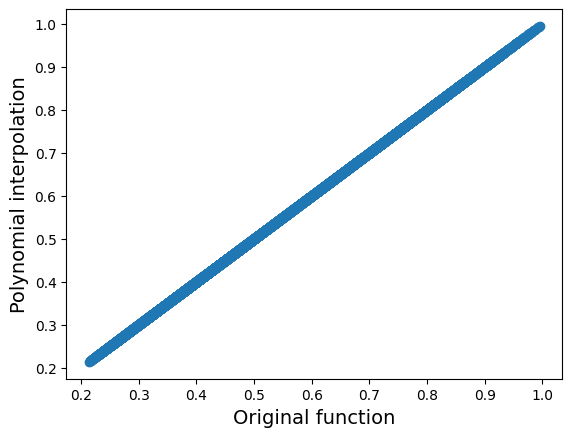

In [13]:
plt.scatter(yy_test, yy_poly)
plt.xlabel("Original function", fontsize=14)
plt.ylabel("Polynomial interpolation", fontsize=14);

In [14]:
nwt_coeffs = nwt_poly.coeffs
exponents = nwt_poly.multi_index.exponents
gen_points = nwt_poly.grid.generating_points

In [15]:
len(mi)

19470

## Base implementation

In [9]:
yy_base = eval_newton_driver_base(xx_test, nwt_coeffs, exponents, gen_points)

In [10]:
assert np.allclose(yy_poly, yy_base)

In [11]:
%%timeit
eval_newton_driver_base(xx_test, nwt_coeffs, exponents, gen_points)

62.3 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba implementation

In [24]:
yy_numba = eval_newton_driver_numba_cpu(xx_test, nwt_coeffs, exponents, gen_points)

In [25]:
assert np.allclose(yy_poly, yy_numba)

ValueError: operands could not be broadcast together with shapes (100000,) (1000000,) 

In [18]:
%%timeit
eval_newton_driver_numba_cpu(xx_test, nwt_coeffs, exponents, gen_points)

14.8 s ± 89.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba parallel implementation

In [27]:
yy_numba_cpu_par = eval_newton_driver_numba_cpu_par(xx_test, nwt_coeffs, exponents, gen_points)

In [20]:
assert np.allclose(yy_poly, yy_numba_cpu_par)

In [21]:
%%timeit
eval_newton_driver_numba_cpu_par(xx_test, nwt_coeffs, exponents, gen_points)

904 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
